# Import packages


In [148]:
import sys, os
sys.path.append('..') # add parent directory to path

import numpy as np
import pandas as pd
# from utils import processing as pr
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
torch.set_printoptions(edgeitems=2, linewidth=75)

from sklearn.preprocessing import MinMaxScaler

In [149]:
# Set the device to GPU if available, else fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [150]:
# ! pip install pyarrow fastparquet tqdm seaborn torch

In [151]:
# # Mount Google drive
# from google.colab import drive
# drive.mount('/content/drive')

# Load Test Data from Previous Notebook (03_combine_datasets.ipynb)
Consider only pickups from Taxi Zone 79 (East Village)

In [152]:
# load data
# ts = pd.read_pickle('data/test/counts_yellow_2023-01_2023-03.pkl')
ts = pd.read_pickle('data/test/adjusted_yellow_2023-01_2023-03_bypulocation.pkl') ## Fewer PU zones
# ts = pd.read_pickle('./drive/MyDrive/Data Science Projects/taxi-forecast/notebooks/data/test/counts_yellow_2023-01_2023-03.pkl')

# Drop 'total_amount'
ts.drop(['total_amount'], axis=1, inplace=True)

# shape of data
print(ts.shape)

# sort
ts.sort_values(['PULocationID', 'pickup_datetime'], inplace=True)

ts.head()

# Number of PU zones
print(len(ts['PULocationID'].unique()))

(136017, 8)
63


# Preprocess data for modelling

Uncomment the print lines to check the tensors and their dimensions

In [153]:
# Drop zone with very sparse time series
n_top_zones = 50
n_bottom_zones = 50
selected_zones_df = ts.groupby('PULocationID')['counts'].sum().sort_values(ascending=False)[:-n_bottom_zones]
display(selected_zones_df)
selected_zones = selected_zones_df.index.to_list()

PULocationID
237    402178
161    381704
236    370714
186    297032
162    294492
142    274938
230    264848
170    242754
163    237694
239    237280
234    230116
48     225143
141    212552
Name: counts, dtype: int32

In [154]:
selected_zones = [56, 79, 90]
# Filter data with selected zones
selected_ts = ts[ts['PULocationID'].isin(selected_zones)].copy()
# ts_2 = ts[ts['PULocationID'].isin(selected_zones)].copy()
print('zones: ', selected_ts['PULocationID'].unique())
display(selected_ts.head())

# Remap zone ID to [0, 1, 2,...] in order to work with nn.Embedding()
def zone_mapping(taxi_data):
    zone_list = sorted(list(taxi_data['PULocationID'].unique()))
    n_zones = len(zone_list)
    zone_dict = dict(zip(zone_list, range(len(zone_list))))
    return zone_dict

zone_dict = zone_mapping(selected_ts)
selected_ts['zone_id'] = selected_ts['PULocationID'].map(zone_dict)

# Pivot wide: each colunm is a time series of a zone
value_cols = ['counts', 'fare_amount']
ts_multi = selected_ts.pivot(index='pickup_datetime', columns='zone_id',  values=value_cols)
display(ts_multi.head())
print(ts_multi.columns)

n_covars = len(value_cols)

zones:  [79 90]


,PULocationID,pickup_datetime,counts,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
13,79,2023-01-01 00:00:00-05:00,253,3.099328,14.793676,2.503122,1.557312,12.808762
76,79,2023-01-01 01:00:00-05:00,265,3.154415,15.820000,2.676000,1.498113,13.296038
139,79,2023-01-01 02:00:00-05:00,241,3.137303,14.581328,2.664813,1.647303,11.250830
202,79,2023-01-01 03:00:00-05:00,257,2.978872,13.764202,2.544553,1.435798,10.309987
265,79,2023-01-01 04:00:00-05:00,165,2.908909,15.702424,3.031818,1.400000,11.449494


counts       fare_amount           
zone_id                      0.0   1.0         0.0        1.0
pickup_datetime                                              
2023-01-01 00:00:00-05:00  253.0  87.0   14.793676  15.641380
2023-01-01 01:00:00-05:00  265.0  53.0   15.820000  14.926414
2023-01-01 02:00:00-05:00  241.0  71.0   14.581328  14.673240
2023-01-01 03:00:00-05:00  257.0  66.0   13.764202  12.527272
2023-01-01 04:00:00-05:00  165.0  58.0   15.702424  15.505172

MultiIndex([(     'counts', 0.0),
            (     'counts', 1.0),
            ('fare_amount', 0.0),
            ('fare_amount', 1.0)],
           names=[None, 'zone_id'])


In [155]:
# Function to reindex the list of sequences --> resulting re-indexed list of sequence 
# is ready to be batched while maintain the time line through batches
def group_chunks(data, batch_size):
    num_batches = len(data) // batch_size
    new_ds = []
    for batch_idx in range(num_batches):
        re_indexed_batch = list(data[batch_idx + num_batches*j] for j in range(batch_size))
        # print('batch length: ', len(re_indexed_batch))
        new_ds += re_indexed_batch
    return new_ds

In [157]:
data = ts_multi

print(type(data))
print(data.shape)
display(data)
print()

# Normalize data - standardize each column independently
# scaler1 normalizes the count columns (to reverse tranform on the target later)
scaler1 = MinMaxScaler()
data1 = scaler1.fit_transform(data.iloc[:,:n_zones])

# scaler1 normalizes other columns
scaler2 = MinMaxScaler()
data2 = scaler2.fit_transform(data.iloc[:,n_zones:])

# then concat all normalized columns
data = np.concatenate([data1, data2], axis=1)
print(type(data))
print(data.shape)
print(data)
print()

# Transpose --> each row is a time series for a given zone
data = data.T
print(type(data))
print(data.shape)
# display(data)
print()

# Convert data to PyTorch tensors
data = torch.tensor(data, dtype=torch.float32).to(device)
print(type(data))
print(data.shape)
print()
display(data)


<class 'pandas.core.frame.DataFrame'>
(2159, 4)


counts        fare_amount           
zone_id                      0.0    1.0         0.0        1.0
pickup_datetime                                               
2023-01-01 00:00:00-05:00  253.0   87.0   14.793676  15.641380
2023-01-01 01:00:00-05:00  265.0   53.0   15.820000  14.926414
2023-01-01 02:00:00-05:00  241.0   71.0   14.581328  14.673240
2023-01-01 03:00:00-05:00  257.0   66.0   13.764202  12.527272
2023-01-01 04:00:00-05:00  165.0   58.0   15.702424  15.505172
...                          ...    ...         ...        ...
2023-03-31 19:00:00-04:00  156.0  144.0   13.253205  12.411111
2023-03-31 20:00:00-04:00  180.0  107.0   13.188889  12.800000
2023-03-31 21:00:00-04:00  212.0  109.0   15.417925  14.090826
2023-03-31 22:00:00-04:00  291.0  108.0   13.490377  13.247222
2023-03-31 23:00:00-04:00  361.0  119.0   14.410803  14.758824

[2159 rows x 4 columns]


<class 'numpy.ndarray'>
(2159, 4)
[[0.42495784 0.48066298 0.25682113 0.53993183]
 [0.44519393 0.29281768 0.28794541 0.50559149]
 [0.40472175 0.39226519 0.25038146 0.49343132]
 ...
 [0.35581788 0.60220994 0.27575209 0.46545756]
 [0.48903879 0.59668508 0.21729728 0.42493863]
 [0.60708263 0.65745856 0.2452101  0.49754201]]

<class 'numpy.ndarray'>
(4, 2159)

<class 'torch.Tensor'>
torch.Size([4, 2159])



tensor([[0.4250, 0.4452,  ..., 0.4890, 0.6071],
        [0.4807, 0.2928,  ..., 0.5967, 0.6575],
        [0.2568, 0.2879,  ..., 0.2173, 0.2452],
        [0.5399, 0.5056,  ..., 0.4249, 0.4975]])

In [ ]:
sequence_length = 24 # size of each slide (over time)
batch_size = len(zone_list) # This is the number of zones


def prepare_seqs(data, n_zones, n_covars, sequence_length):
    # Prepare the data into list of sequences (pair of input and target sequences)
    # data_pp will be a list of lists, each inner list contain the slices of info over time for each zone
    data_pp = []   
    
    for z in range(n_zones):
        zone_series = data[z::n_covars, :]
        series_length = zone_series.shape[-1]
        sequence_idxs = range(0, series_length - sequence_length - 1, sequence_length)
        zone_series_pp = [(
            zone_series[:, seq_idx:     seq_idx + sequence_length    ], 
            zone_series[0, seq_idx + 1: seq_idx + sequence_length + 1]
        ) for seq_idx in sequence_idxs]

        data_pp.append(zone_series_pp)
    return data_pp

data_pp = prepare_seqs(data, n_zones, n_covars, sequence_length)
# print(len(data_pp))
# print(len(data_pp[0]))
# print(data_pp[0][0], data_pp[0][1]) # zone 1
# print(data_pp[1][0], data_pp[1][1]) # zone 2

In [168]:
sl = 24 # size of each slide (over time)
batch_size = len(zone_list) # This is the number of zones

def pp_to_chunks(data_pp, batch_size, train_portion=0.8):
    cut_idx = int(len(data_pp[0]) * 0.8)
    zone_train_data = [zone_seq[:cut_idx] for zone_seq in data_pp]
    zone_valid_data = [zone_seq[cut_idx:] for zone_seq in data_pp]
    zone_data = (zone_train_data, zone_valid_data)
    zone_chunks = []
    for zone_data_series in zone_data:
        flattened_zones = [i for zone_seq in zone_train_data for i in zone_seq]
        zone_chuncks.append(group_chunks(flattened_zones, batch_size))
    return zone_chunks

# Create Train and Validation sets - fix cutoff index to drop last few obs that are not enough to formm a batch
cut = int(len(data_pp[0]) * 0.8)

train_data = [s[:cut] for s in data_pp]
valid_data = [s[cut:] for s in data_pp] 
# print('length of train_data: ', len(train_data))
# print('length of each series in train_data: ', len(train_data[0]))
# print('first item of train_data[0]: ', train_data[0][0])
# print('length of each series in valid_data: ', len(valid_data[0]))
# print()

# Concatenate the 3 series into a long chain
train_set = [i for s in train_data for i in s ]
valid_set = [i for s in valid_data for i in s ]
# print('length of concat train set: ', len(train_set))
# print('length of concat valid set: ', len(valid_set))
# print('first item of train_set[0]: ', train_set[0])
# print()

# Reindex with group_chunks() --> Concatenate & Reindex helps with dataloader which takes in a list
train_set = group_chunks(train_set, batch_size)
valid_set = group_chunks(valid_set, batch_size)
# print('length of reindexed train set: ', len(train_set))
# print('length of reindexed valid set: ', len(valid_set))
# print()


train_set, valid_set = pp_to_chunks(data_pp, batch_size, train_portion=0.8)


In [169]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

# Check size of Train and Validation sets in the dataloaders
print('N batches in train loader: ', len(list(train_loader)))
print('N batches in valid loader: ', len(list(valid_loader)))
print()

# # shape of first batch: 2 stacks
# print('shape of first batch (2 stacks) in train set: ')
# print(list(train_loader)[0]) # first batch
# print(list(train_loader)[0][0].size()) # input
# print(list(train_loader)[0][1].size()) # target
# print()

# # first pair of input & target in the first batch --> First time step of zone 1
# print('first pair of input & target in the first batch in train set: ')
# print(list(train_loader)[0][0][0]) # input
# print(list(train_loader)[0][1][0]) # target
# print()

# # second pair of input & target in the first batch --> First time step of zone 2 
# print('second pair of input & target in the first batch in train set: ')
# print(list(train_loader)[0][0][1]) # input
# print(list(train_loader)[0][1][1]) # target
# print()

# # first pair of input & target in the second batch --> Second time step of zone 1
# print('first pair of input & target in the second batch in train set: ')
# print(list(train_loader)[1][0][0]) # input
# print(list(train_loader)[1][1][0]) # target
# print()

# # second pair of input & target in the second batch --> Second time step of zone 2
# print('second pair of input & target in the second batch in train set: ')
# print(list(train_loader)[1][0][1]) # input
# print(list(train_loader)[1][1][1]) # target
# print()

N batches in train loader:  71
N batches in valid loader:  18



# Modelling

## RNN

In [177]:
class RNN_MultiSeries_Model(nn.Module):
    def __init__(self, embed_dim_inputs, input_size=n_covars, hidden_size=50, output_size=1, num_layers=1):
        super(RNN_MultiSeries_Model, self).__init__()
        self.cat_embed = nn.Embedding(embed_dim_inputs[0], embed_dim_inputs[1])
        # self.embed_dropout = nn.Dropout(0.4)
        self.rnn = nn.RNN(embed_dim_inputs[1] + input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.h = torch.zeros(num_layers, batch_size, hidden_size)

    def forward(self, x_cat, x_cont):
        emb = self.cat_embed(x_cat)
        # Expand the embedding matrix to concatenate to the continuous times series
        emb_expanded = emb.unsqueeze(dim=-2).expand((-1, x_cont.size(-2), -1)) 
        # emb_expanded = self.embed_dropout(emb_expanded)
        x = torch.cat([emb_expanded, x_cont], dim=-1)
        out, h = self.rnn(x, self.h)
        self.h = h.detach()
        out = self.fc(out)
        return out

    def reset(self): self.h.zero_()

In [178]:
input_size = n_covars
hidden_size = 50
output_size = 1
num_layers = 1

zone_id_list = torch.tensor(sorted(list(ts_2['zone_id'].unique()))).long().to(device)
embed_dim_inputs = len(zone_id_list), min(50, (len(zone_id_list)+1)//2)
print('dimension', embed_dim_inputs)

model = RNN_MultiSeries_Model(embed_dim_inputs, 
                              input_size, 
                              hidden_size, 
                              output_size, 
                              num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)


dimension (2, 1)


In [ ]:
def transform_batch(batch_X, batch_y):
    batch_X = batch_X.moveaxis(-2, -1)
    batch_y = batch_y.unsqueeze(dim=-1)
    return batch_X, batch_y

In [172]:
# Training loop for multiple series RNN/LSTM
num_epochs = 1000

## to keep track of if validation loss went up
times_valid_loss_went_up_in_a_row = 0

## an initial value
min_valid_loss = float("inf")

def train_epoch(train_loader, model, criterion, zone_id_list):
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        
        batch_X, batch_y = transform_batch(batch_X, batch_y)

        preds = model(zone_id_list, batch_X)

        train_loss = criterion(preds, batch_y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    model.reset()
    
    return avg_train_loss

def validate_epoch(valid_loader, model, criterion, zone_id_list):
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
        
            batch_X, batch_y = transform_batch(batch_X, batch_y)
            
            preds = model(zone_id_list, batch_X)
            valid_loss = criterion(preds, batch_y)

            epoch_valid_loss += valid_loss.item()
    
    avg_valid_loss = epoch_valid_loss / len(valid_loader)
    model.reset()
    
    return avg_valid_loss


valid_loss_list = []

for epoch in range(num_epochs):
    ## Train
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        
        batch_X, batch_y = transform_batch(batch_X, batch_y)

        preds = model(zone_id_list, batch_X)

        train_loss = criterion(preds, batch_y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    model.reset()

    ## Validate
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
        
            batch_X, batch_y = transform_batch(batch_X, batch_y)
            
            preds = model(zone_id_list, batch_X)
            valid_loss = criterion(preds, batch_y)

            epoch_valid_loss += valid_loss.item()
    
    avg_valid_loss = epoch_valid_loss / len(valid_loader)
    model.reset()

    ## print out Train and Valiation loss for every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}')

    ## Early Stopping: check if the error went up or down
    valid_loss_list.append(avg_valid_loss)

    # if it went down
    if valid_loss_list[-1] < min_valid_loss:
        # record the new minimum val error
        min_valid_loss = valid_loss_list[-1]

        # reset our up counter
        times_valid_loss_went_up_in_a_row = 0
    # if it went up
    else:
        # add to the counter
        times_valid_loss_went_up_in_a_row = times_valid_loss_went_up_in_a_row + 1
        # if this is the 20th time in a row it has gone up
        if times_valid_loss_went_up_in_a_row == 20:
            # stop early
            break

Epoch [10/1000], Train Loss: 0.0071, Validation Loss: 0.0069
Epoch [20/1000], Train Loss: 0.0071, Validation Loss: 0.0069
Epoch [30/1000], Train Loss: 0.0057, Validation Loss: 0.0072
Epoch [40/1000], Train Loss: 0.0051, Validation Loss: 0.0062
Epoch [50/1000], Train Loss: 0.0053, Validation Loss: 0.0057
Epoch [60/1000], Train Loss: 0.0046, Validation Loss: 0.0047
Epoch [70/1000], Train Loss: 0.0043, Validation Loss: 0.0046
Epoch [80/1000], Train Loss: 0.0042, Validation Loss: 0.0044


Test Loss: 0.0049


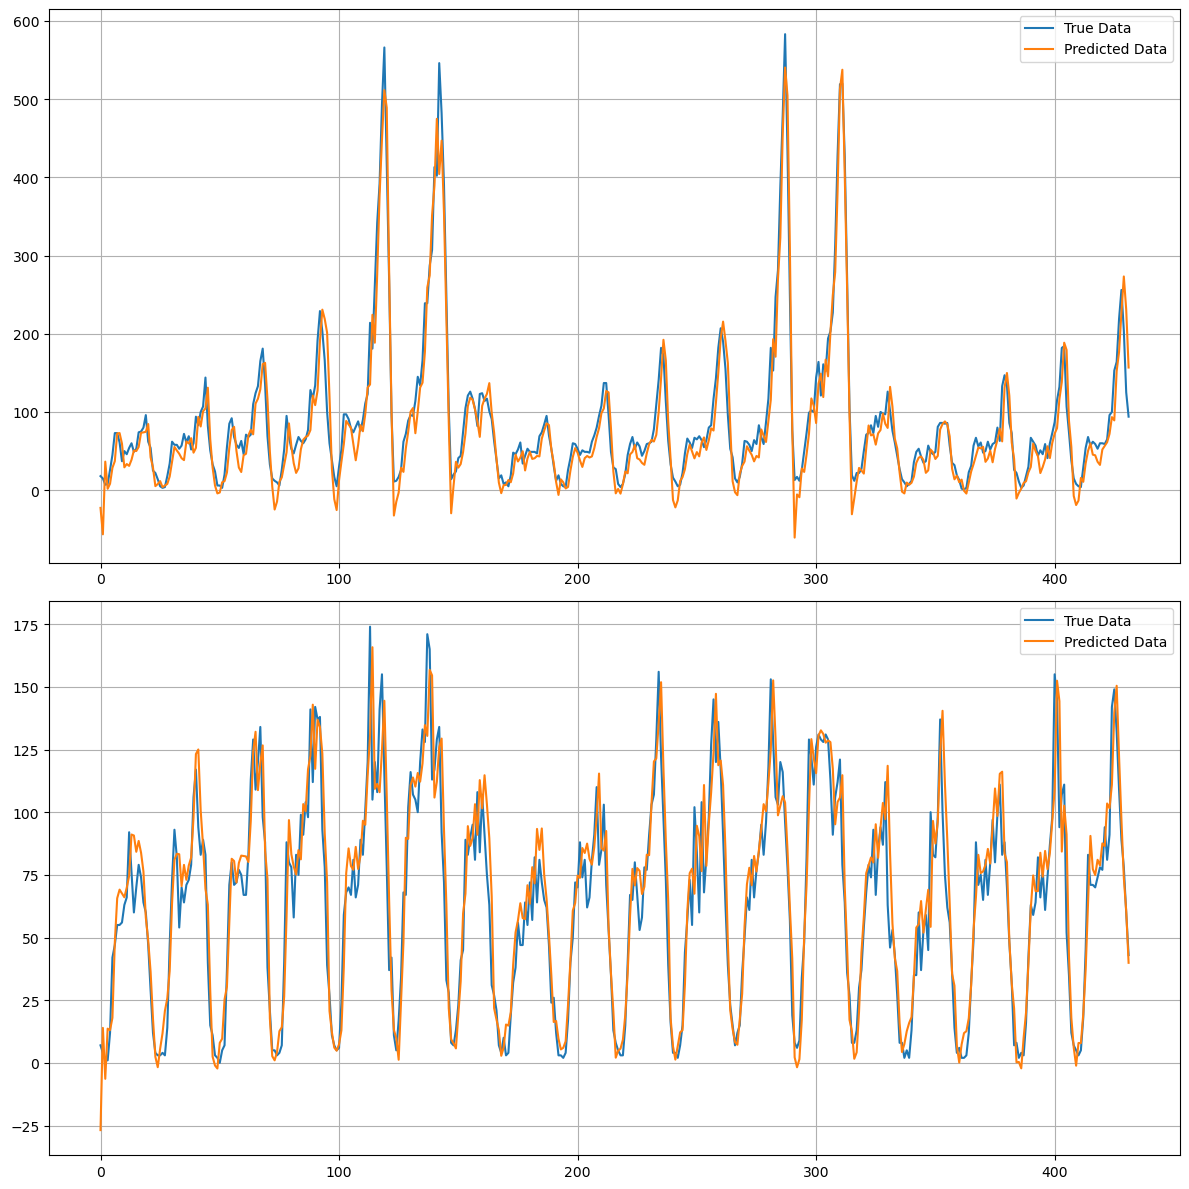

In [173]:
model.eval()
with torch.no_grad():
    test_preds = []
    test_target = []

    for batch_X, batch_y in valid_loader:
        
        batch_X, batch_y = transform_batch(batch_X, batch_y)
        
        
        
        preds = model(zone_id_list, batch_X)
        
        test_preds.append(preds)
        test_target.append(batch_y)
         
    test_preds = torch.cat(test_preds, dim=-2)
    test_target = torch.cat(test_target, dim=-2)
    
    test_loss = criterion(test_preds, test_target)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Change the dimension to work with scaler
    test_preds = test_preds.numpy().squeeze(-1).T
    test_target = test_target.numpy().squeeze(-1).T
    
    # Inverse transform to get the original scale
    test_preds = scaler1.inverse_transform(test_preds)
    test_target = scaler1.inverse_transform(test_target)
    
    # Transpose again
    test_preds = test_preds.T
    test_target = test_target.T
    
    
    # Plot
    fig, axs = plt.subplots(len(zone_id_list), 1, figsize=(12, 12))
    for c in range(test_target.shape[0]):   
        axs[c].plot(range(test_target.shape[1]), test_target[c], label='True Data')
        axs[c].plot(range(test_target.shape[1]), test_preds[c], label='Predicted Data')
        axs[c].legend()
        axs[c].grid(True)
    plt.tight_layout()
    plt.show()


## LSTM

In [179]:
class LSTM_MultiSeries_Model(nn.Module):
    def __init__(self, embed_dim_inputs, input_size=n_covars, hidden_size=50, output_size=1, num_layers=1):
        super(LSTM_MultiSeries_Model, self).__init__()
        self.cat_embed = nn.Embedding(embed_dim_inputs[0], embed_dim_inputs[1])
        # self.embed_dropout = nn.Dropout(0.4)
        self.lstm = nn.LSTM(embed_dim_inputs[1] + input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.h = [torch.zeros(num_layers, batch_size, hidden_size) for _ in range(2)]

    def forward(self, x_cat, x_cont):
        emb = self.cat_embed(x_cat)
        # Expand the embedding matrix to concatenate to the continuous times series
        emb_expanded = emb.unsqueeze(dim=-2).expand((-1, x_cont.size(-2), -1)) 
        # emb_expanded = self.embed_dropout(emb_expanded)
        x = torch.cat([emb_expanded, x_cont], dim=-1)
        out, h = self.lstm(x, self.h)
        self.h = [h_.detach() for h_ in h]
        out = self.fc(out)
        return out

    def reset(self): 
        for h in self.h: h.zero_()

In [180]:
input_size = n_covars
hidden_size = 50
output_size = 1
num_layers = 1

zone_id_list = torch.tensor(sorted(list(ts_2['zone_id'].unique()))).long().to(device)
embed_dim_inputs = len(zone_id_list), min(50, (len(zone_id_list)+1)//2)
print('dimension', embed_dim_inputs)

model = LSTM_MultiSeries_Model(embed_dim_inputs, 
                               input_size,
                               hidden_size,
                               output_size,
                               num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)


dimension (2, 1)


In [181]:
# Training loop for multiple series RNN/LSTM
num_epochs = 1000

## to keep track of if validation loss went up
times_valid_loss_went_up_in_a_row = 0

## an initial value
min_valid_loss = float("inf")

valid_loss_list = []

for epoch in range(num_epochs):
    ## Train
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        
        batch_X, batch_y = transform_batch(batch_X, batch_y)

        preds = model(zone_id_list, batch_X)
        train_loss = criterion(preds, batch_y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    model.reset()

    ## Validate
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
        
            batch_X, batch_y = transform_batch(batch_X, batch_y)
            
            preds = model(zone_id_list, batch_X)
            valid_loss = criterion(preds, batch_y)

            epoch_valid_loss += valid_loss.item()
    
    avg_valid_loss = epoch_valid_loss / len(valid_loader)
    model.reset()

    ## print out Train and Valiation loss for every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}')

    ## Early Stopping: check if the error went up or down
    valid_loss_list.append(avg_valid_loss)

    # if it went down
    if valid_loss_list[-1] < min_valid_loss:
        # record the new minimum val error
        min_valid_loss = valid_loss_list[-1]

        # reset our up counter
        times_valid_loss_went_up_in_a_row = 0
    # if it went up
    else:
        # add to the counter
        times_valid_loss_went_up_in_a_row = times_valid_loss_went_up_in_a_row + 1
        # if this is the 20th time in a row it has gone up
        if times_valid_loss_went_up_in_a_row == 20:
            # stop early
            break

Epoch [10/1000], Train Loss: 0.0070, Validation Loss: 0.0084
Epoch [20/1000], Train Loss: 0.0065, Validation Loss: 0.0070
Epoch [30/1000], Train Loss: 0.0044, Validation Loss: 0.0048
Epoch [40/1000], Train Loss: 0.0039, Validation Loss: 0.0044
Epoch [50/1000], Train Loss: 0.0039, Validation Loss: 0.0041
Epoch [60/1000], Train Loss: 0.0036, Validation Loss: 0.0040
Epoch [70/1000], Train Loss: 0.0036, Validation Loss: 0.0038
Epoch [80/1000], Train Loss: 0.0034, Validation Loss: 0.0039
Epoch [90/1000], Train Loss: 0.0036, Validation Loss: 0.0040
Epoch [100/1000], Train Loss: 0.0032, Validation Loss: 0.0036


Test Loss: 0.0037


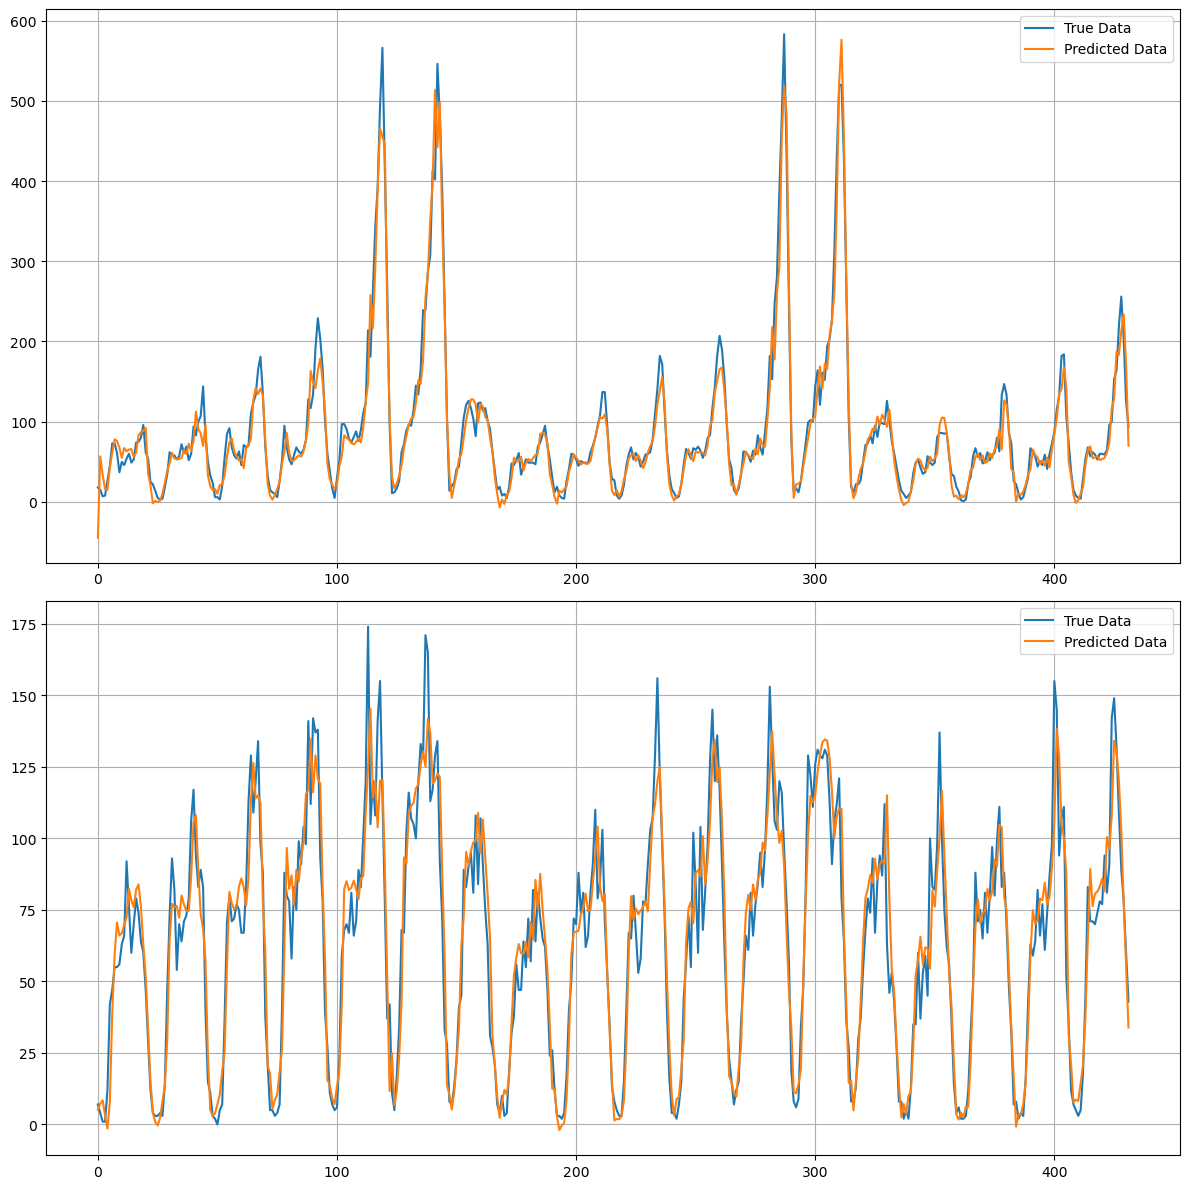

In [183]:
model.eval()
with torch.no_grad():
    test_preds = []
    test_target = []

    for batch_X, batch_y in valid_loader:
        batch_X = batch_X.moveaxis(-2, -1)
        batch_y = batch_y.unsqueeze(dim=-1)
        
        preds = model(zone_id_list, batch_X)
        
        test_preds.append(preds)
        test_target.append(batch_y)
         
    test_preds = torch.cat(test_preds, dim=-2)
    test_target = torch.cat(test_target, dim=-2)
    
    test_loss = criterion(test_preds, test_target)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Change the dimension to work with scaler
    test_preds = test_preds.numpy().squeeze(-1).T
    test_target = test_target.numpy().squeeze(-1).T
    
    # Inverse transform to get the original scale
    test_preds = scaler1.inverse_transform(test_preds)
    test_target = scaler1.inverse_transform(test_target)
    
    # Transpose again
    test_preds = test_preds.T
    test_target = test_target.T
    
    # Plot
    fig, axs = plt.subplots(len(zone_id_list), 1, figsize=(12, 12))
    for c in range(test_target.shape[0]):   
        axs[c].plot(range(test_target.shape[1]), test_target[c], label='True Data')
        axs[c].plot(range(test_target.shape[1]), test_preds[c], label='Predicted Data')
        axs[c].legend()
        axs[c].grid(True)
    plt.tight_layout()
    plt.show()
